# VAE (not nan with 100 epochs and latent space 200)

In [1]:
import os
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from tensorflow.keras import Model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

2023-03-13 17:30:25.173942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.__version__

'2.10.0'

In [3]:
from tensorflow.keras.utils import image_dataset_from_directory

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
    # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
              tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

In [5]:
ds = image_dataset_from_directory('/Users/sophiabouchama/code/cuboidmaster/asha-fm/raw_data/zelle', label_mode=None, image_size=(448, 448), batch_size=16)

Found 2360 files belonging to 1 classes.


2023-03-13 17:30:34.092281: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
ds = ds.map(lambda x: x/255)
# ds = ds.map(lambda x: (x, x))

In [7]:
imgs = ds.as_numpy_iterator().__next__()

In [8]:
imgs.shape

(16, 448, 448, 3)

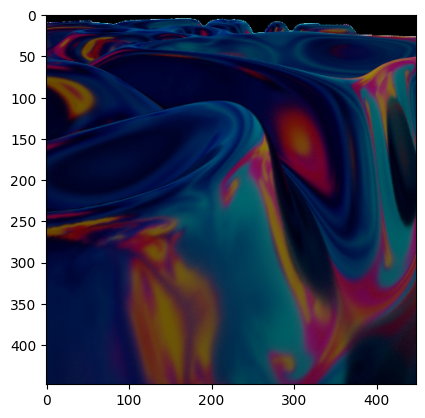

In [9]:
plt.imshow(imgs[0])


In [10]:
X_train = ds.map(lambda x : x/255).batch(16).prefetch(tf.data.AUTOTUNE)

In [11]:
from keras.layers import Lambda

In [12]:
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.layers import Layer

In [13]:
import tensorflow as tf
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
latent_dim = 200


input_image = Input(shape=(448, 448, 3))
    
x = Conv2D(32, (3, 3), padding='same', activation="relu")(input_image)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation="relu")(x)
#x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
encoder_output = Dense(latent_dim, activation="relu")(x)

z_mean = tf.keras.layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
encoder = tf.keras.Model(input_image, [z_mean, z_log_var, z], name="encoder")

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 448, 448, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 448, 448, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 224, 224, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [15]:
latent_inputs = tf.keras.Input(shape=(latent_dim,))  
x = Dense(7*7*64, activation='tanh')(latent_inputs)
x = Reshape((7, 7, 64))(x)
x = Conv2DTranspose(128, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(128, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(64, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(32, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(16, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=2, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)
x = Conv2DTranspose(8, (3, 3), strides=1, padding='same', activation="relu")(x)


    
decoder_output = Conv2DTranspose(3, (3, 3), strides=2, padding='same', activation='sigmoid')(x)
    
decoder = Model(inputs=latent_inputs, outputs=decoder_output, name="decoder")
decoder.summary()
    

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              630336    
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      73856     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 14, 14, 128)      147584    
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 14, 14, 128)      1475

In [16]:
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf.keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [17]:
ds

<MapDataset element_spec=TensorSpec(shape=(None, 448, 448, 3), dtype=tf.float32, name=None)>

In [18]:
#next_images = ds.as_numpy_iterator().__next__()

In [19]:
#vae.decoder(vae.encoder(next_images[0].reshape(-1,448,448,3))[0])

In [20]:
class CallbackSaveModel(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            self.model.save_weights(f'/home/jupyter/model_{epoch}')

save_model = CallbackSaveModel()

In [21]:
vae = VAE(encoder, decoder)
#vae.compile(optimizer=tf.keras.optimizers.Adam())

In [22]:
# vae.fit(ds, epochs=10, callbacks=[save_model])

In [23]:
# vae.save_weights('save_model_100epochs_200latdim')

In [24]:
vae.load_weights('../saved_models/model_vae_2500')

# Original Image

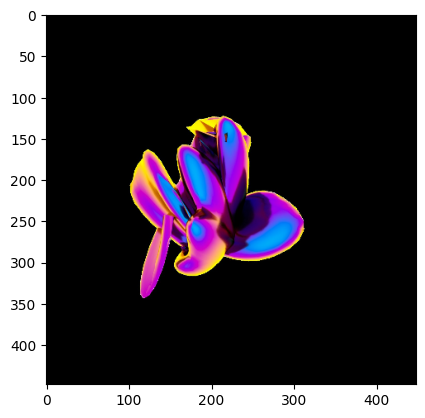

In [25]:
plt.imshow(imgs[5])

# VAE reconstructed image

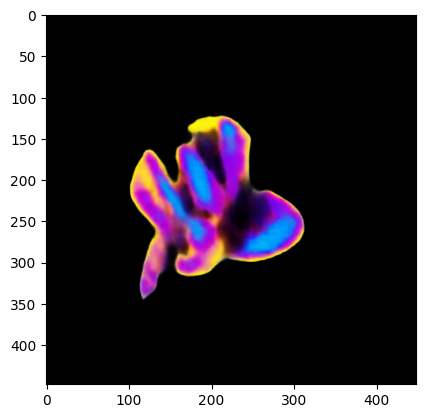

In [26]:
encoded_image = vae.encoder(imgs[5].reshape(-1,448,448,3))
decoded_image = vae.decoder(encoded_image[0])
plt.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))

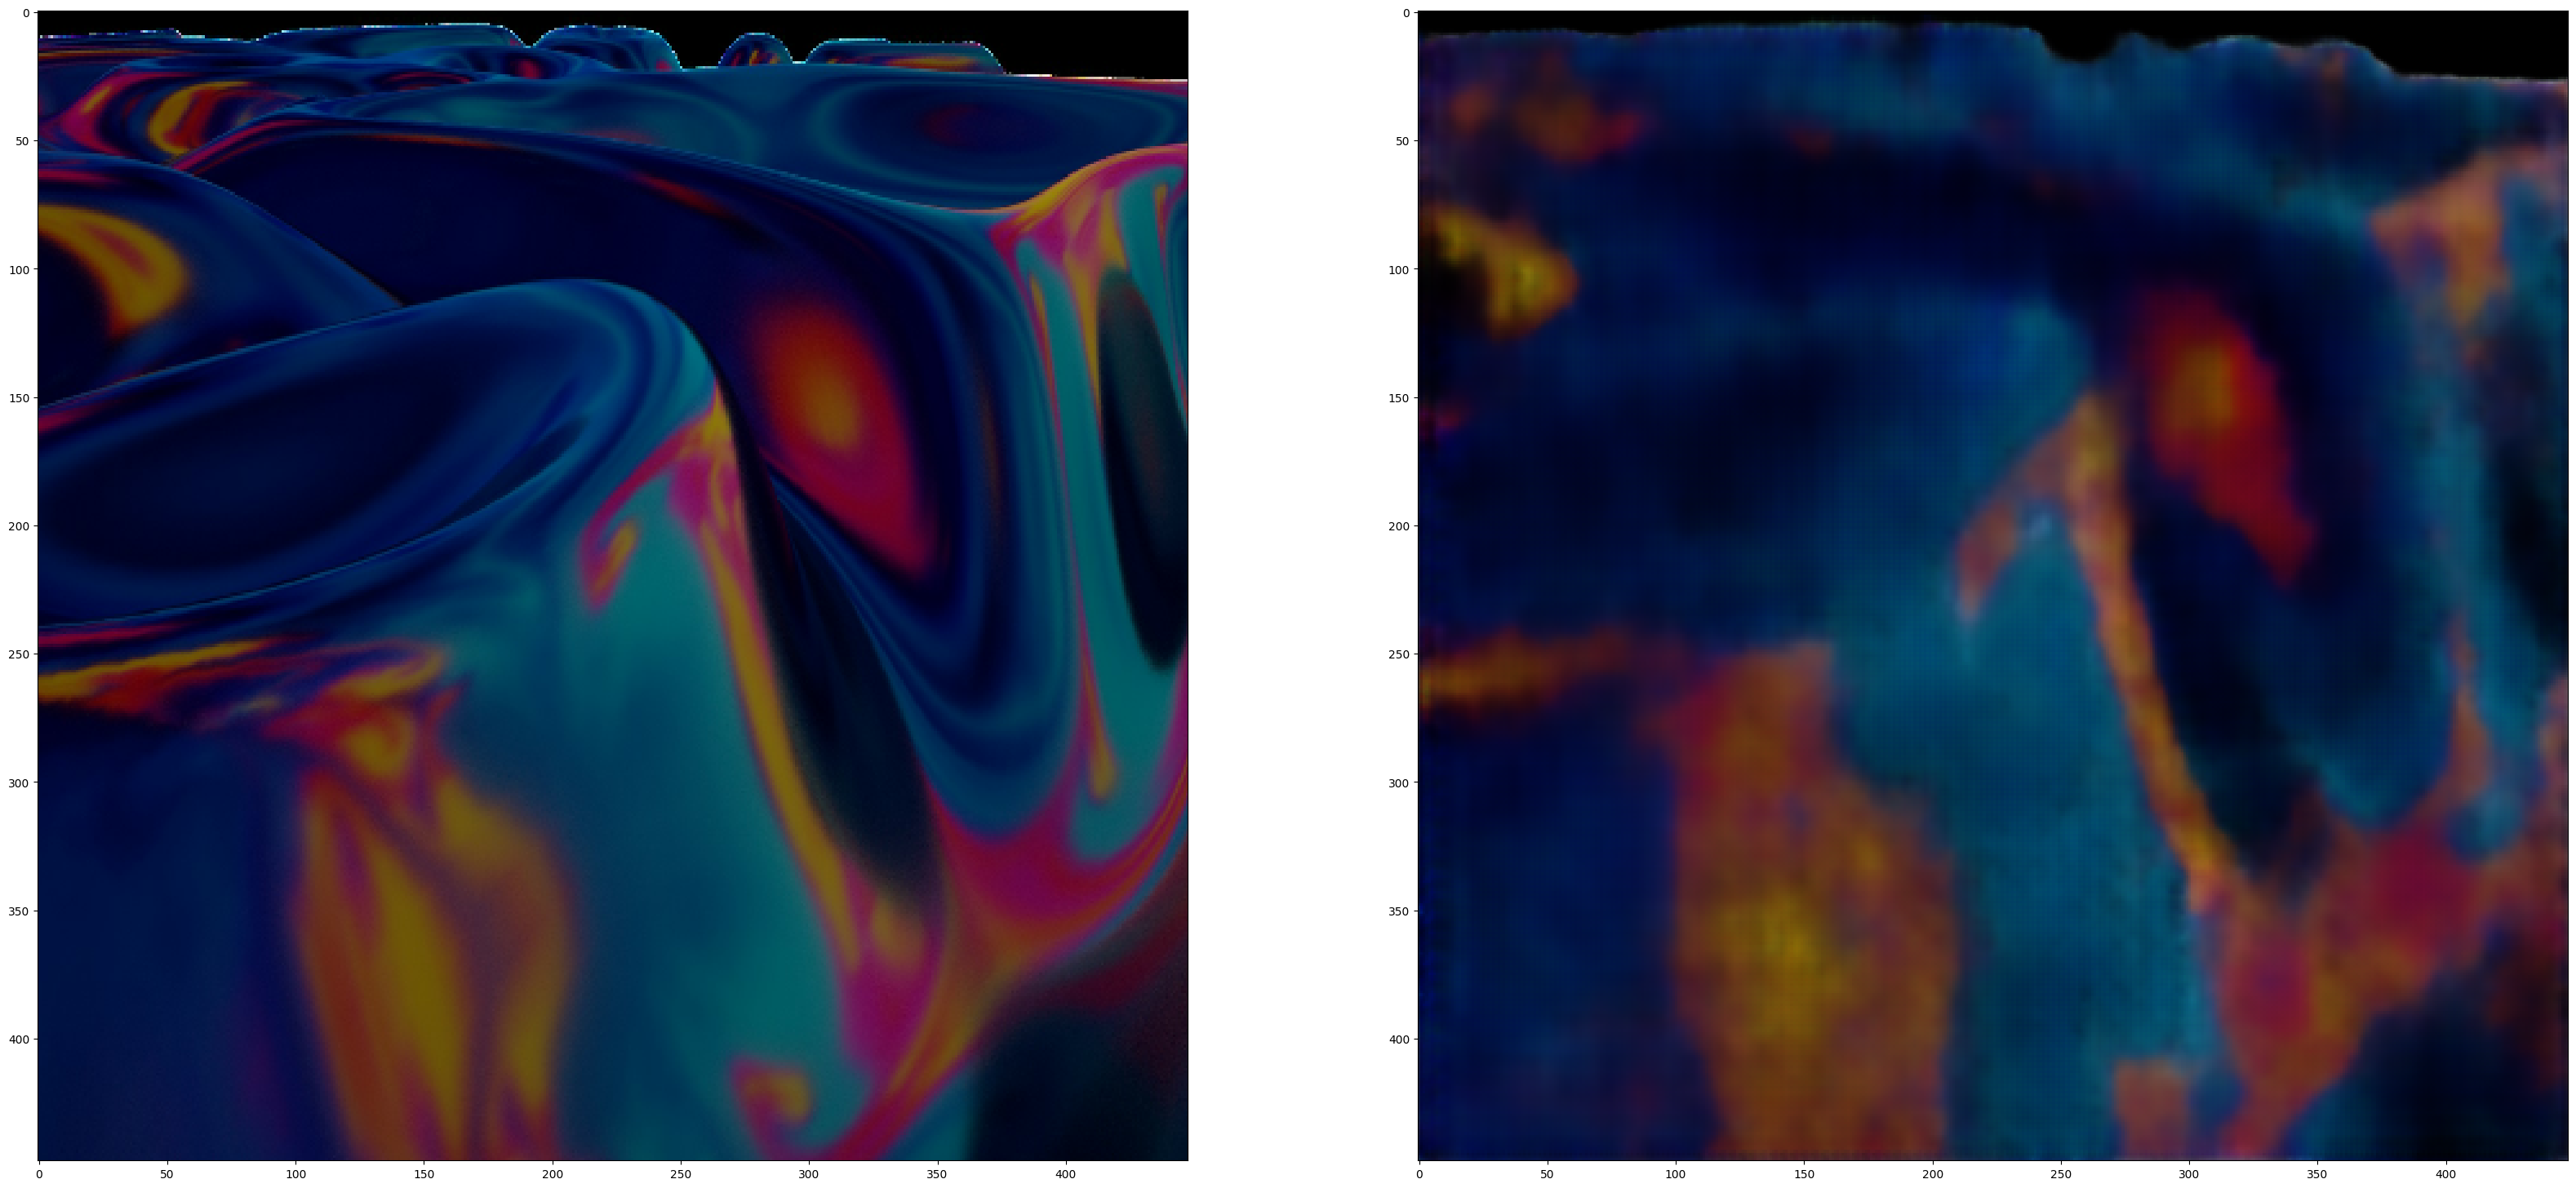

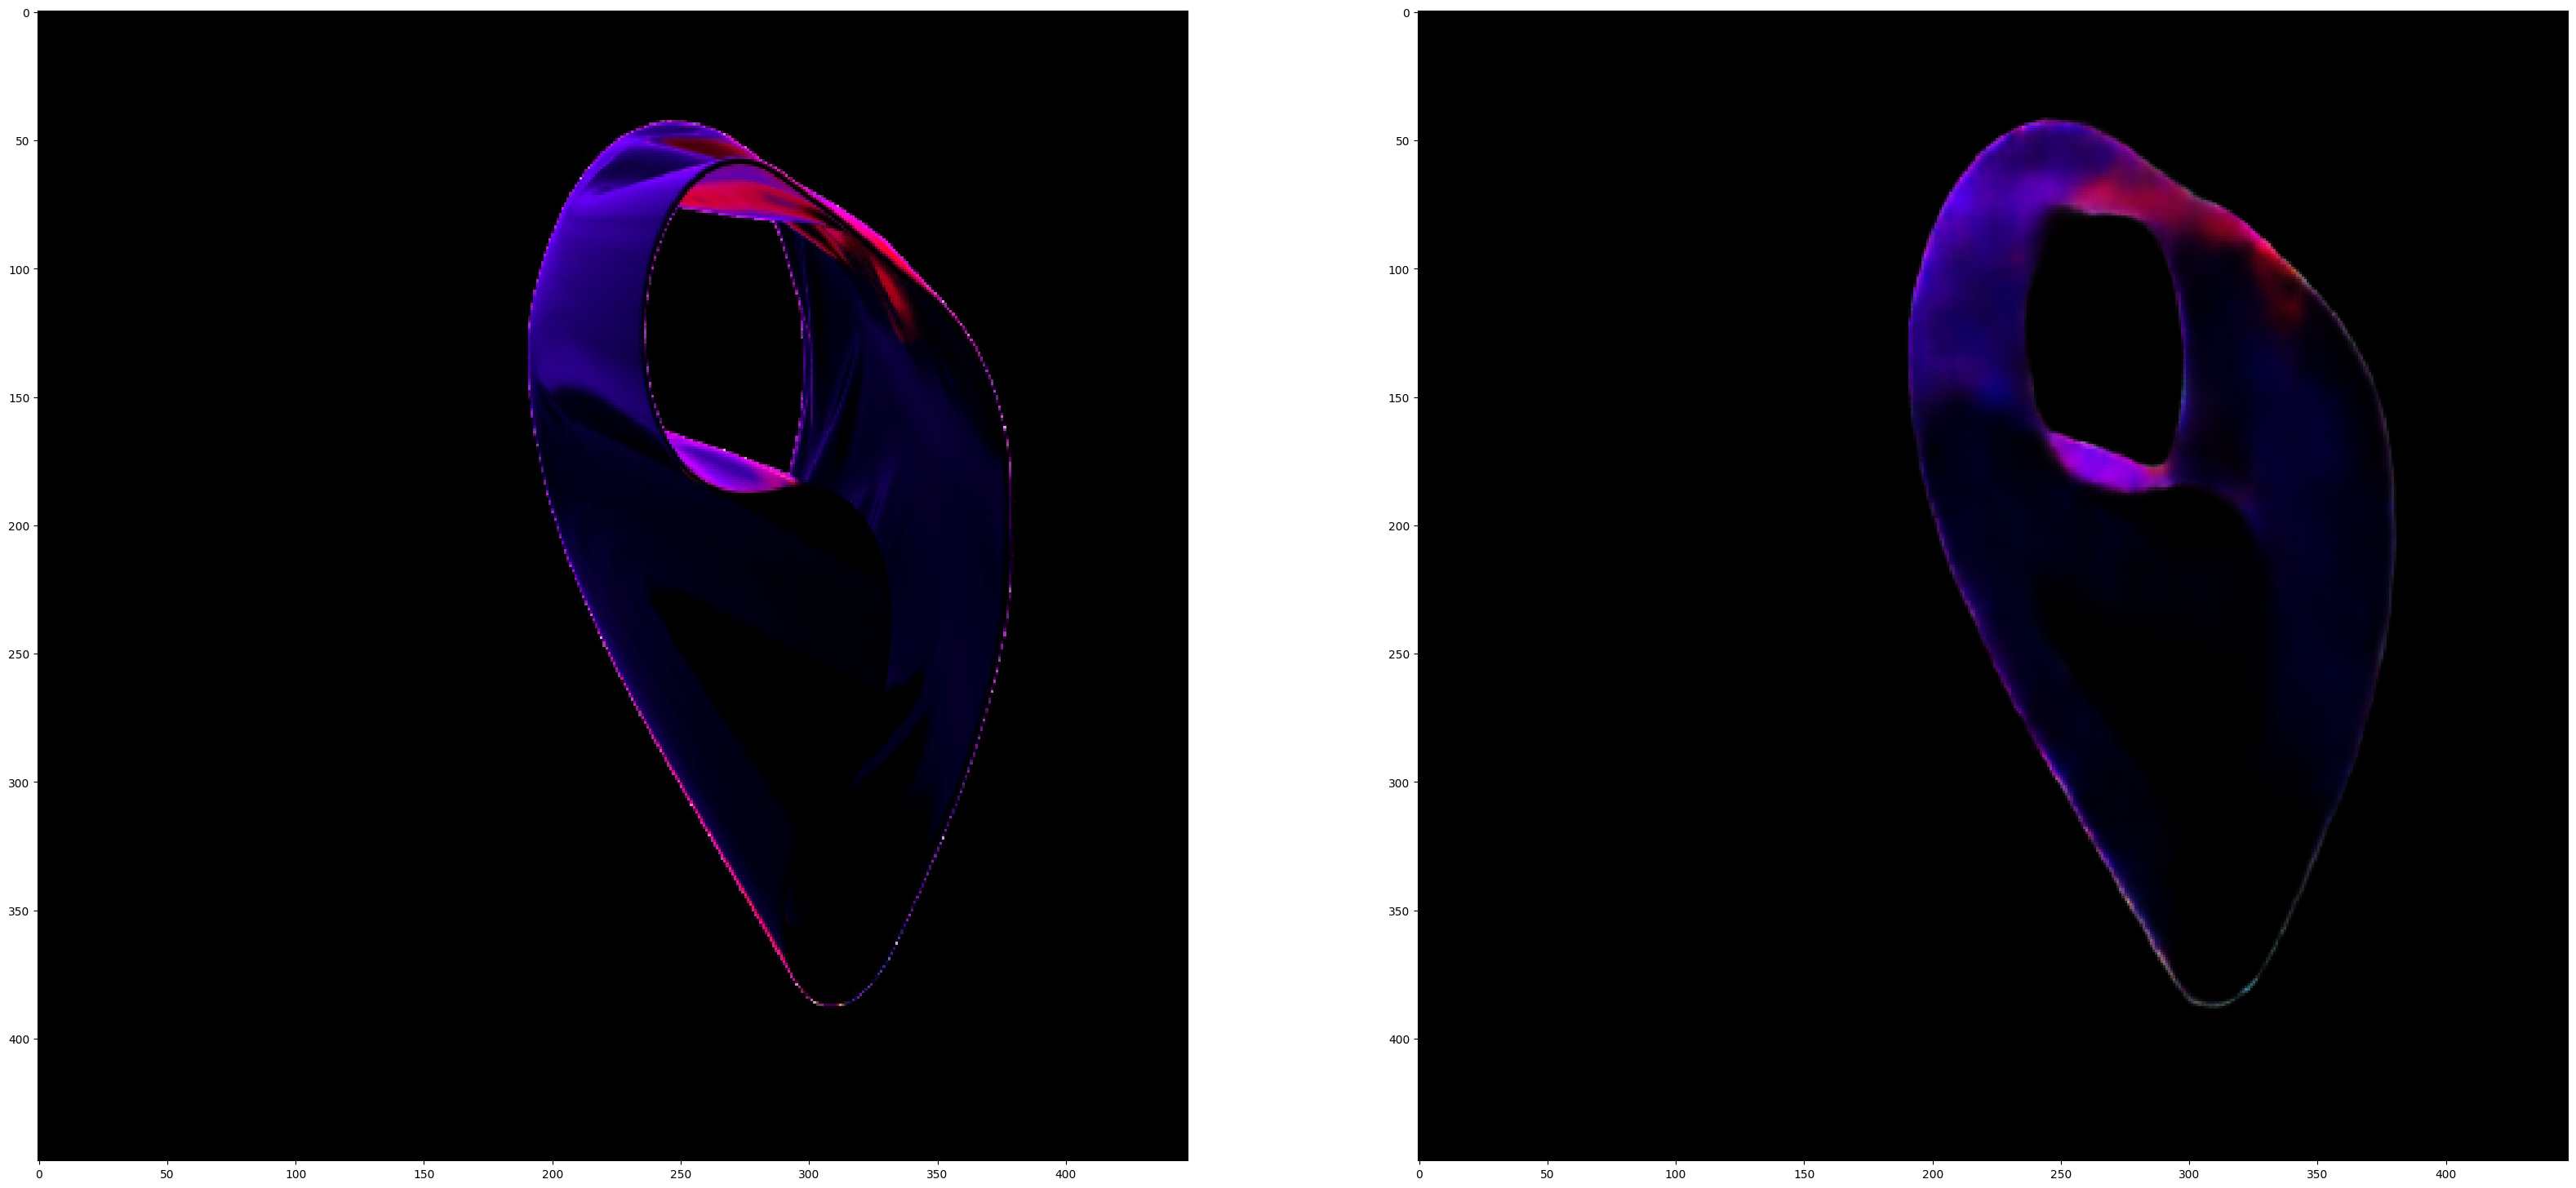

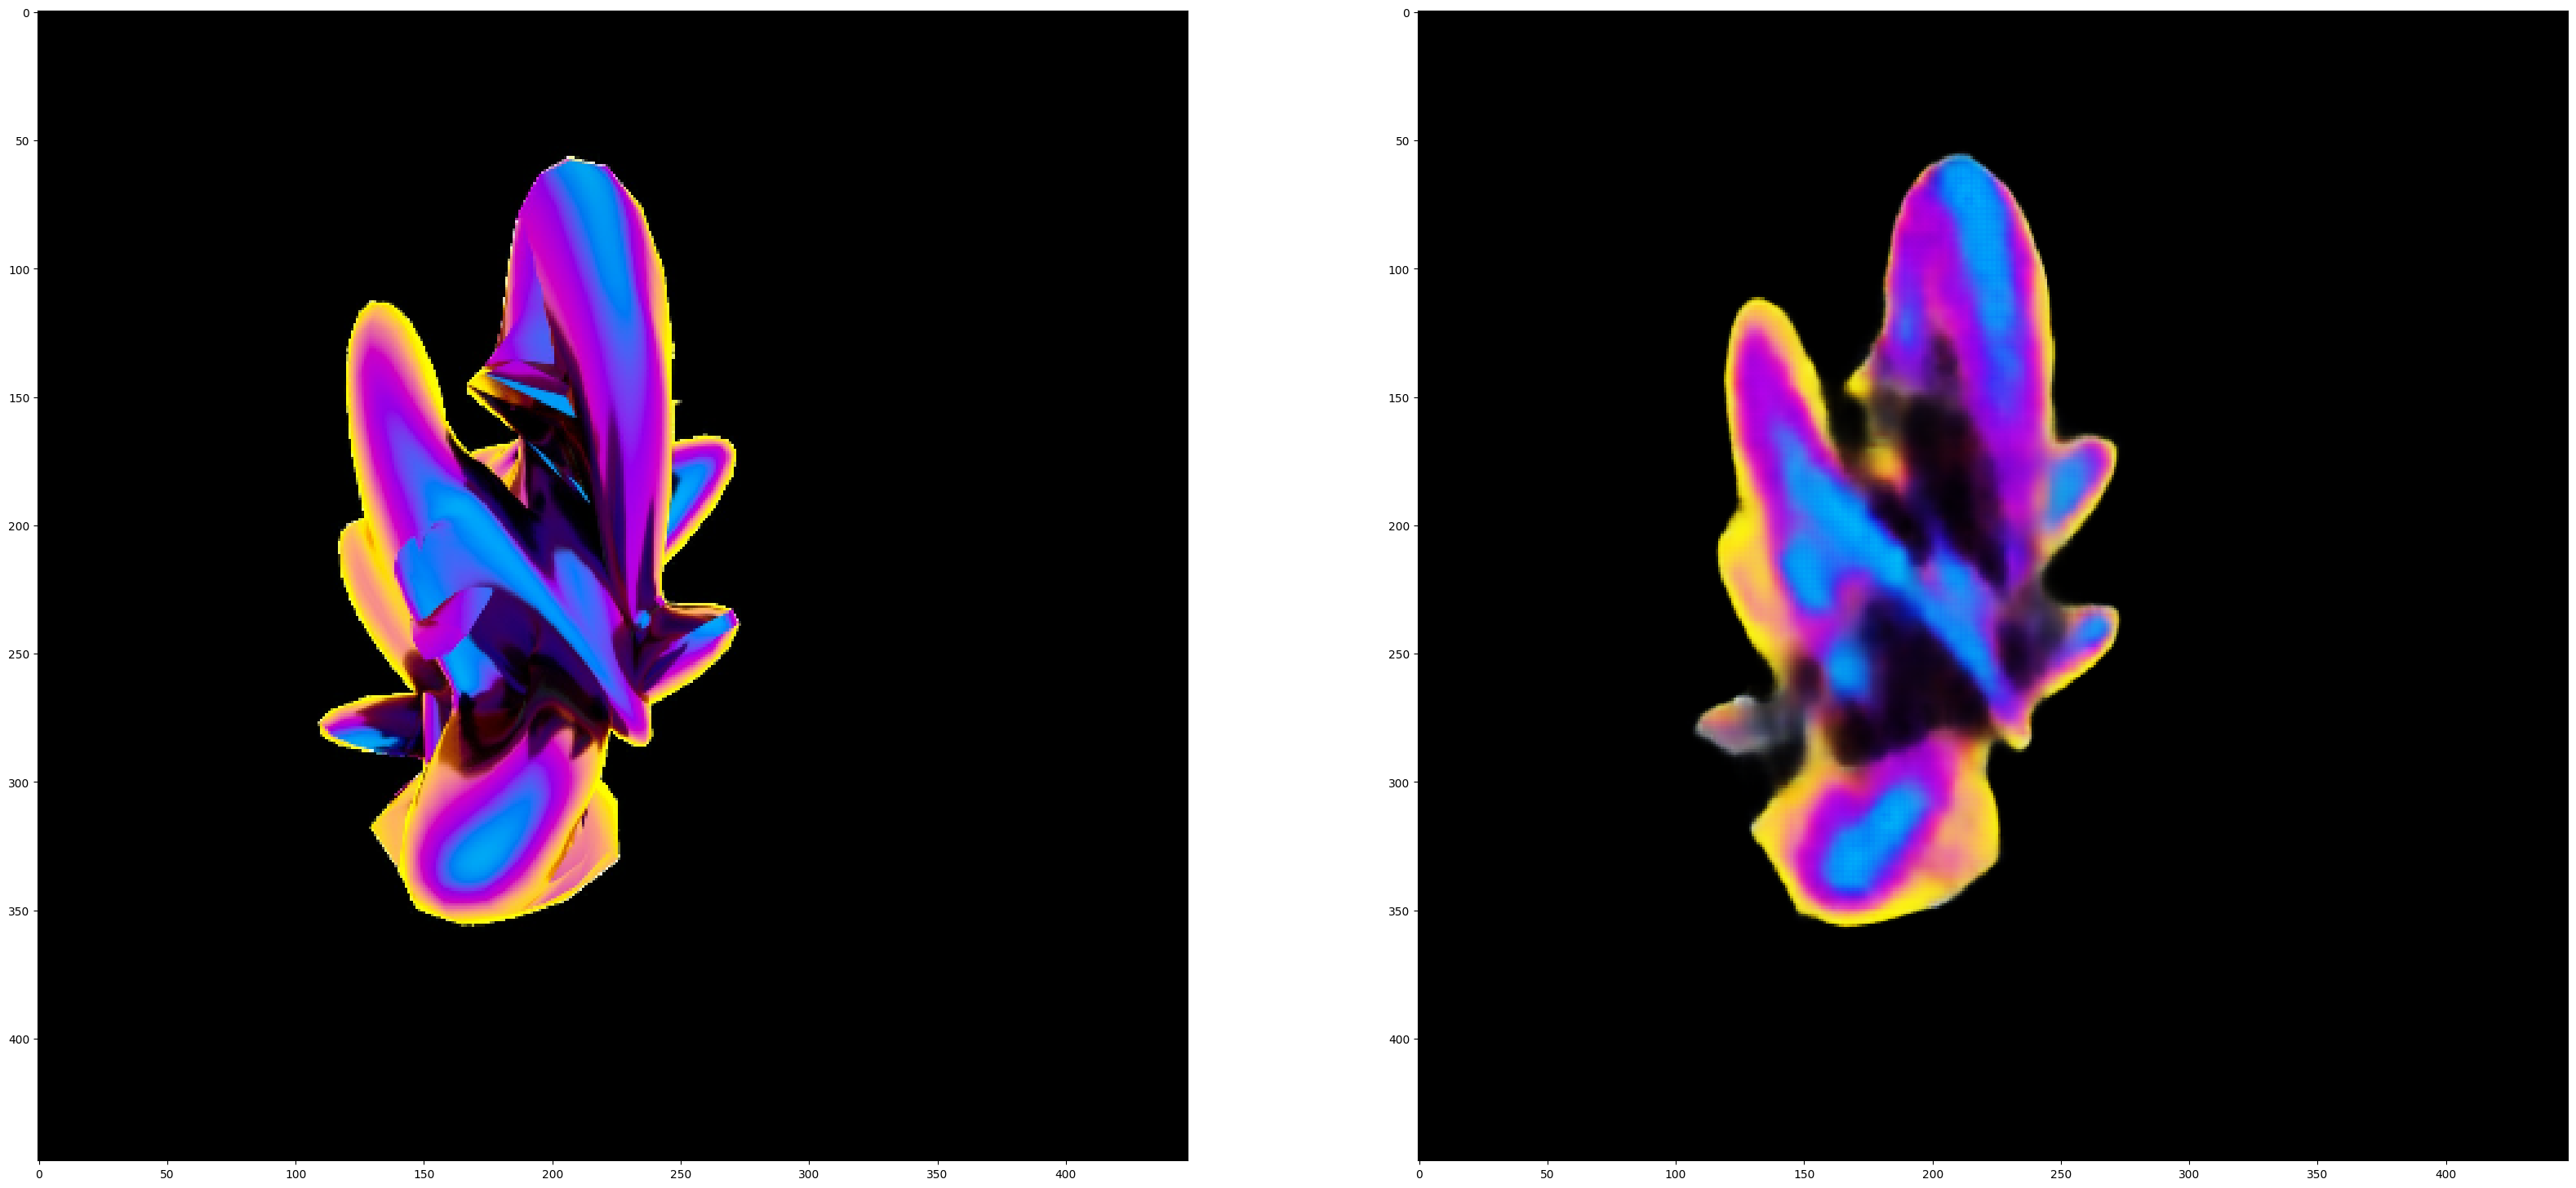

In [27]:
for i in range(3):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,20))
    encoded_image = vae.encoder(imgs[i].reshape(-1,448,448,3))
    decoded_image = vae.decoder(encoded_image[0])
    ax2.imshow((decoded_image.numpy().reshape(448,448,3) * 255).astype(np.uint8))
    ax1.imshow(imgs[i])

In [37]:
from spleeter.separator import Separator

In [38]:
separator = Separator('spleeter:4stems')

In [39]:
import librosa
y, sr = librosa.load('audiotest.wav', sr=44100)

In [40]:
y = y.reshape((-1, 1))

In [41]:


# Perform the separation :
prediction = separator.separate(y)

INFO:tensorflow:Apply unet for vocals_spectrogram
Instructions for updating:
Colocations handled automatically by placer.
INFO:tensorflow:Apply unet for drums_spectrogram
INFO:tensorflow:Apply unet for bass_spectrogram
INFO:tensorflow:Apply unet for other_spectrogram
INFO:tensorflow:Restoring parameters from pretrained_models/4stems/model


In [42]:
prediction['bass']

array([[-2.0338500e-02, -2.0243518e-02],
       [-2.0411210e-02, -2.0313876e-02],
       [-2.0482495e-02, -2.0382768e-02],
       ...,
       [ 1.4089968e-05,  1.3801596e-05],
       [ 8.4636804e-06,  8.2521210e-06],
       [-5.1072593e-06, -5.0533681e-06]], dtype=float32)

In [43]:
separator.separate_to_file('audiotest.wav', 'audio_split', duration=30)

INFO:spleeter:File audio_split/audiotest/other.wav written succesfully
INFO:spleeter:File audio_split/audiotest/bass.wav written succesfully
INFO:spleeter:File audio_split/audiotest/drums.wav written succesfully
INFO:spleeter:File audio_split/audiotest/vocals.wav written succesfully
